# Entrenamiento
En el siguiente notebook se muestran los resultados obtenidos utilizando las dos estrategias de para balancear el dataset propuestas en el notebook Dataset_Split

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2022-10-05 13:35:02.492409: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-05 13:35:02.769730: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-05 13:35:03.515010: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2022-10-05 13:35:03.515064: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: can

## Utilizando dataset de valores minimos
Es considerado una buena practica el uso de dataGenerators para manejar las transformaciones que se realizan en las imagenes durante el proceso de entrenamiento

In [2]:
img_width = 250
img_height = 250
batch_size = 16
epochs = 100


# Define data augmentations to be performed at training stage
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# data generator used on the validation and testing splits (only rescale)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_split_path = "../data/train/training_dataset_bal_min/training"
valid_split_path = "../data/train/training_dataset_bal_min/validation"
test_split_path = "../data/train/training_dataset_bal_min/testing"


train_generator = train_datagen.flow_from_directory(
    train_split_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    valid_split_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

testing_generator = validation_datagen.flow_from_directory(
    test_split_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 1632 images belonging to 12 classes.
Found 204 images belonging to 12 classes.
Found 6596 images belonging to 12 classes.


## Build models 
Para este entrenamiento de decide utilizar ResNet, MobileNet y a modo de ejemplo se incluye un modelo sencillo de CNN, para esto es necesario crear una funcion que se encarge de cargar los modelos segun lo requerido

In [3]:
# Generate a simple model to test
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K

# training using mobilenet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.applications import ResNet50

import sklearn.metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [8]:
def build_model(model_name):
    
    # set your input size based on the keras image data format
    if K.image_data_format() == 'channels_first':
        input_shape = (3, img_width, img_height)
    else:
        input_shape = (img_width, img_height, 3)
    
    if model_name =="MobileNetV2":
        input_tensor = Input(shape=(input_shape))

        base_model = MobileNetV2(
            include_top=False,
            weights='imagenet',
            input_tensor=input_tensor,
            input_shape=input_shape,
            pooling='avg')

        for layer in base_model.layers:
            layer.trainable = True  # trainable has to be false in order to freeze the layers

        op = Dense(256, activation='relu')(base_model.output)
        op = Dropout(.25)(op) 
        output_tensor = Dense(12, activation='softmax')(op)

        model = Model(inputs=input_tensor, outputs=output_tensor)        
        return model
    
    elif model_name == "ResNetV2":
        input_tensor = Input(shape=(input_shape))

        base_model = ResNet50(
            include_top=False,
            weights='imagenet',
            input_tensor=input_tensor,
            input_shape=input_shape,
            pooling='avg')

        for layer in base_model.layers:
            layer.trainable = False  # trainable has to be false in order to freeze the layers

        op = Dense(256, activation='relu')(base_model.output)
        op = Dropout(.25)(op)     
        output_tensor = Dense(12, activation='softmax')(op)

        model = Model(inputs=input_tensor, outputs=output_tensor)        
        return model
    
    elif model_name == "SimpleCNN":
        model = Sequential()
        model.add(Conv2D(32, (3, 3), input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(32, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(64))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(12))
        model.add(Activation('softmax'))
        
        return model
    
    else:
        print("Invalid option")

# Training A simple model architecture

In [6]:
MODEL_NAME = "SimpleCNN"
model_dir = "../models"
model_filepath=os.path.join(model_dir, "bck_{}.h5".format(MODEL_NAME))
checkpoint = ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
callbacks_list = [checkpoint, es]

model = build_model(MODEL_NAME)
model.summary()
model.compile(optimizer=keras.optimizers.Adam(lr=2e-4),
              loss='categorical_crossentropy',                
              metrics=['accuracy'])

history = model.fit_generator(
        train_generator,        
        steps_per_epoch= 1632 // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=callbacks_list,
        validation_steps=204 // batch_size)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 248, 248, 32)      896       
                                                                 
 activation_5 (Activation)   (None, 248, 248, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 124, 124, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 122, 122, 32)      9248      
                                                                 
 activation_6 (Activation)   (None, 122, 122, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                  

/home/lito/.local/bin/.virtualenvs/candaml-env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_54727/1321711539.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100


2022-10-05 12:15:22.843181: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-10-05 12:15:23.787317: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


102/102 [==============================] - ETA: 0s - loss: 2.4926 - accuracy: 0.0907
Epoch 1: val_accuracy improved from -inf to 0.17708, saving model to ../models/bck_SimpleCNN.h5
102/102 [==============================] - 17s 134ms/step - loss: 2.4926 - accuracy: 0.0907 - val_loss: 2.4318 - val_accuracy: 0.1771
Epoch 2/100
102/102 [==============================] - ETA: 0s - loss: 2.4343 - accuracy: 0.1189
Epoch 2: val_accuracy improved from 0.17708 to 0.22396, saving model to ../models/bck_SimpleCNN.h5
102/102 [==============================] - 13s 127ms/step - loss: 2.4343 - accuracy: 0.1189 - val_loss: 2.3024 - val_accuracy: 0.2240
Epoch 3/100
102/102 [==============================] - ETA: 0s - loss: 2.3416 - accuracy: 0.1599
Epoch 3: val_accuracy improved from 0.22396 to 0.29167, saving model to ../models/bck_SimpleCNN.h5
102/102 [==============================] - 13s 130ms/step - loss: 2.3416 - accuracy: 0.1599 - val_loss: 2.1545 - val_accuracy: 0.2917
Epoch 4/100
102/102 [====

102/102 [==============================] - ETA: 0s - loss: 1.6759 - accuracy: 0.3915
Epoch 56: val_accuracy did not improve from 0.64062
102/102 [==============================] - 12s 122ms/step - loss: 1.6759 - accuracy: 0.3915 - val_loss: 1.2304 - val_accuracy: 0.5938
Epoch 57/100
102/102 [==============================] - ETA: 0s - loss: 1.6842 - accuracy: 0.3781
Epoch 57: val_accuracy improved from 0.64062 to 0.65625, saving model to ../models/bck_SimpleCNN.h5
102/102 [==============================] - 12s 120ms/step - loss: 1.6842 - accuracy: 0.3781 - val_loss: 1.1861 - val_accuracy: 0.6562
Epoch 58/100
102/102 [==============================] - ETA: 0s - loss: 1.7350 - accuracy: 0.3683
Epoch 58: val_accuracy did not improve from 0.65625
102/102 [==============================] - 12s 122ms/step - loss: 1.7350 - accuracy: 0.3683 - val_loss: 1.1762 - val_accuracy: 0.6146
Epoch 59/100
102/102 [==============================] - ETA: 0s - loss: 1.6632 - accuracy: 0.3775
Epoch 59: val_a

Epoch 84/100
102/102 [==============================] - ETA: 0s - loss: 1.5953 - accuracy: 0.4173
Epoch 84: val_accuracy did not improve from 0.71354
102/102 [==============================] - 12s 119ms/step - loss: 1.5953 - accuracy: 0.4173 - val_loss: 1.0167 - val_accuracy: 0.7135
Epoch 85/100
102/102 [==============================] - ETA: 0s - loss: 1.6139 - accuracy: 0.4087
Epoch 85: val_accuracy did not improve from 0.71354
102/102 [==============================] - 12s 122ms/step - loss: 1.6139 - accuracy: 0.4087 - val_loss: 1.0481 - val_accuracy: 0.7031
Epoch 86/100
102/102 [==============================] - ETA: 0s - loss: 1.5579 - accuracy: 0.4357
Epoch 86: val_accuracy did not improve from 0.71354
102/102 [==============================] - 12s 118ms/step - loss: 1.5579 - accuracy: 0.4357 - val_loss: 0.9895 - val_accuracy: 0.6875
Epoch 87/100
102/102 [==============================] - ETA: 0s - loss: 1.5662 - accuracy: 0.4418
Epoch 87: val_accuracy improved from 0.71354 to 0.

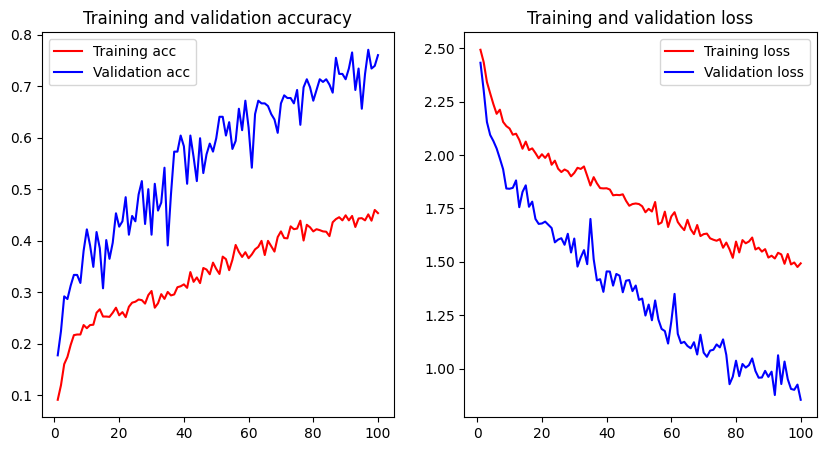

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig(os.path.join(model_dir,"{}_acc.png".format(MODEL_NAME)))
plt.subplot(122)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig(os.path.join(model_dir,"{}_loss.png".format(MODEL_NAME)))
plt.show()

As we can see, the results shown from the simpleCNN model are very poor, we will use mobilenet in the next step

# Training a Mobilenet model

In [9]:
MODEL_NAME = "MobileNetV2"
model_dir = "../models"
model_filepath=os.path.join(model_dir, "bck_{}.h5".format(MODEL_NAME))
checkpoint = ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
callbacks_list = [checkpoint, es]

model_mobile = build_model(MODEL_NAME)
model_mobile.summary()
model_mobile.compile(optimizer=keras.optimizers.Adam(lr=2e-4),
              loss='categorical_crossentropy',                
              metrics=['accuracy'])

history_mobile = model_mobile.fit_generator(
        train_generator,        
        steps_per_epoch= 1632 // batch_size,
        epochs=100,
        validation_data=validation_generator,
        callbacks=callbacks_list,
        validation_steps=204 // batch_size)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 125, 125, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 125, 125, 32  128         ['Conv1[0][0]']                  
                                )                                                           

 ization)                                                                                         
                                                                                                  
 block_3_expand_relu (ReLU)     (None, 63, 63, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 65, 65, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 32, 32, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 32, 32, 144)  576        ['block_3_depthwise[0][0]']      
 malizatio

                                                                                                  
 block_6_project_BN (BatchNorma  (None, 16, 16, 64)  256         ['block_6_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 16, 16, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 16, 16, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 16, 16, 384)  0           ['block_7_expand_BN[0][0]']      
          

 block_10_depthwise_BN (BatchNo  (None, 16, 16, 384)  1536       ['block_10_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 16, 16, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 16, 16, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 16, 16, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_

 block_14_expand_relu (ReLU)    (None, 8, 8, 960)    0           ['block_14_expand_BN[0][0]']     
                                                                                                  
 block_14_depthwise (DepthwiseC  (None, 8, 8, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 8, 8, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 8, 8, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_

/tmp/ipykernel_54727/3704859427.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_mobile = model_mobile.fit_generator(


102/102 [==============================] - ETA: 0s - loss: 1.1602 - accuracy: 0.6146
Epoch 1: val_accuracy improved from -inf to 0.27604, saving model to ../models/bck_MobileNetV2.h5
102/102 [==============================] - 16s 135ms/step - loss: 1.1602 - accuracy: 0.6146 - val_loss: 2.7960 - val_accuracy: 0.2760
Epoch 2/100
102/102 [==============================] - ETA: 0s - loss: 0.5086 - accuracy: 0.8309
Epoch 2: val_accuracy improved from 0.27604 to 0.31771, saving model to ../models/bck_MobileNetV2.h5
102/102 [==============================] - 13s 129ms/step - loss: 0.5086 - accuracy: 0.8309 - val_loss: 2.8820 - val_accuracy: 0.3177
Epoch 3/100
102/102 [==============================] - ETA: 0s - loss: 0.3724 - accuracy: 0.8775
Epoch 3: val_accuracy did not improve from 0.31771
102/102 [==============================] - 13s 129ms/step - loss: 0.3724 - accuracy: 0.8775 - val_loss: 3.6137 - val_accuracy: 0.2865
Epoch 4/100
102/102 [==============================] - ETA: 0s - loss

Epoch 28/100
102/102 [==============================] - ETA: 0s - loss: 0.1022 - accuracy: 0.9681
Epoch 28: val_accuracy did not improve from 0.90104
102/102 [==============================] - 13s 128ms/step - loss: 0.1022 - accuracy: 0.9681 - val_loss: 0.5218 - val_accuracy: 0.8854
Epoch 29/100
102/102 [==============================] - ETA: 0s - loss: 0.0743 - accuracy: 0.9792
Epoch 29: val_accuracy did not improve from 0.90104
102/102 [==============================] - 13s 128ms/step - loss: 0.0743 - accuracy: 0.9792 - val_loss: 0.4207 - val_accuracy: 0.8958
Epoch 30/100
102/102 [==============================] - ETA: 0s - loss: 0.0475 - accuracy: 0.9853
Epoch 30: val_accuracy did not improve from 0.90104
102/102 [==============================] - 13s 127ms/step - loss: 0.0475 - accuracy: 0.9853 - val_loss: 0.6700 - val_accuracy: 0.8490
Epoch 31/100
102/102 [==============================] - ETA: 0s - loss: 0.0838 - accuracy: 0.9761
Epoch 31: val_accuracy did not improve from 0.9010

Epoch 56/100
102/102 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.9859
Epoch 56: val_accuracy improved from 0.94792 to 0.95312, saving model to ../models/bck_MobileNetV2.h5
102/102 [==============================] - 14s 133ms/step - loss: 0.0391 - accuracy: 0.9859 - val_loss: 0.3064 - val_accuracy: 0.9531
Epoch 57/100
102/102 [==============================] - ETA: 0s - loss: 0.0710 - accuracy: 0.9792
Epoch 57: val_accuracy did not improve from 0.95312
102/102 [==============================] - 13s 128ms/step - loss: 0.0710 - accuracy: 0.9792 - val_loss: 0.3703 - val_accuracy: 0.9375
Epoch 58/100
102/102 [==============================] - ETA: 0s - loss: 0.0677 - accuracy: 0.9804
Epoch 58: val_accuracy did not improve from 0.95312
102/102 [==============================] - 13s 128ms/step - loss: 0.0677 - accuracy: 0.9804 - val_loss: 0.3744 - val_accuracy: 0.9479
Epoch 59/100
102/102 [==============================] - ETA: 0s - loss: 0.0418 - accuracy: 0.9847


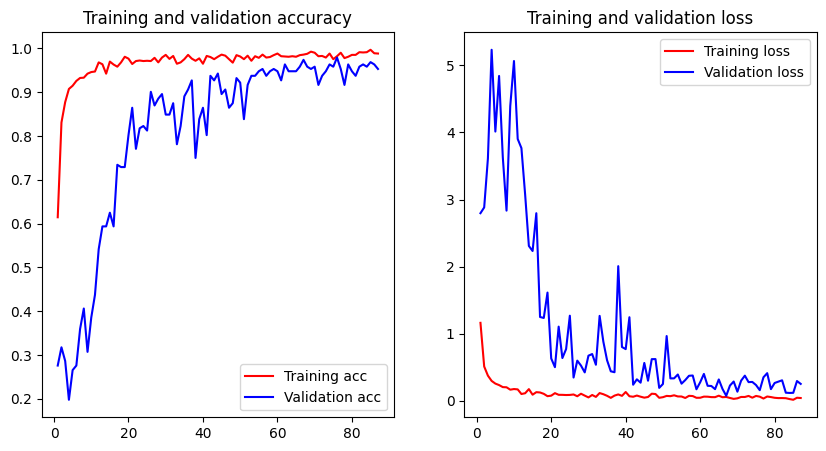

In [11]:
acc = history_mobile.history['accuracy']
val_acc = history_mobile.history['val_accuracy']
loss = history_mobile.history['loss']
val_loss = history_mobile.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig(os.path.join(model_dir,"{}_acc.png".format(MODEL_NAME)))
plt.subplot(122)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig(os.path.join(model_dir,"{}_acc_loss.png".format(MODEL_NAME)))
plt.show()

Using a mobileNet provides a better performance than the previous tested model, however based on the obtained curves, this model could have an overffitting problem.

# Training Using ResNet
This model was trained using transfer learning

In [9]:
MODEL_NAME = "ResNetV2"
model_dir = "../models"
model_filepath=os.path.join(model_dir, "bck_{}.h5".format(MODEL_NAME))
checkpoint = ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
callbacks_list = [checkpoint, es]

model_res = build_model(MODEL_NAME)
model_res.summary()
model_res.compile(optimizer=keras.optimizers.Adam(lr=2e-4),
              loss='categorical_crossentropy',                
              metrics=['accuracy'])

history_res = model_res.fit_generator(
        train_generator,        
        steps_per_epoch= 1632 // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=callbacks_list,
        validation_steps=204 // batch_size)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 256, 256, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 125, 125, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 63, 63, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 63, 63, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 63, 63, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 63, 63, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 8, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

/tmp/ipykernel_5002/1094693063.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_res = model_res.fit_generator(


102/102 [==============================] - ETA: 0s - loss: 2.5828 - accuracy: 0.0846
Epoch 1: val_accuracy improved from -inf to 0.08854, saving model to ../models/bck_ResNetV2.h5
102/102 [==============================] - 17s 149ms/step - loss: 2.5828 - accuracy: 0.0846 - val_loss: 2.4970 - val_accuracy: 0.0885
Epoch 2/100
102/102 [==============================] - ETA: 0s - loss: 2.5047 - accuracy: 0.0999
Epoch 2: val_accuracy did not improve from 0.08854
102/102 [==============================] - 13s 129ms/step - loss: 2.5047 - accuracy: 0.0999 - val_loss: 2.4757 - val_accuracy: 0.0833
Epoch 3/100
102/102 [==============================] - ETA: 0s - loss: 2.4683 - accuracy: 0.1029
Epoch 3: val_accuracy improved from 0.08854 to 0.13542, saving model to ../models/bck_ResNetV2.h5
102/102 [==============================] - 14s 134ms/step - loss: 2.4683 - accuracy: 0.1029 - val_loss: 2.4461 - val_accuracy: 0.1354
Epoch 4/100
102/102 [==============================] - ETA: 0s - loss: 2.44

102/102 [==============================] - ETA: 0s - loss: 2.1310 - accuracy: 0.2549
Epoch 28: val_accuracy did not improve from 0.33854
102/102 [==============================] - 13s 130ms/step - loss: 2.1310 - accuracy: 0.2549 - val_loss: 2.1195 - val_accuracy: 0.2708
Epoch 29/100
102/102 [==============================] - ETA: 0s - loss: 2.1269 - accuracy: 0.2647
Epoch 29: val_accuracy did not improve from 0.33854
102/102 [==============================] - 13s 130ms/step - loss: 2.1269 - accuracy: 0.2647 - val_loss: 2.1084 - val_accuracy: 0.2500
Epoch 30/100
102/102 [==============================] - ETA: 0s - loss: 2.1177 - accuracy: 0.2531
Epoch 30: val_accuracy improved from 0.33854 to 0.34375, saving model to ../models/bck_ResNetV2.h5
102/102 [==============================] - 14s 134ms/step - loss: 2.1177 - accuracy: 0.2531 - val_loss: 2.0720 - val_accuracy: 0.3438
Epoch 31/100
102/102 [==============================] - ETA: 0s - loss: 2.0964 - accuracy: 0.2635
Epoch 31: val_ac

Epoch 56/100
102/102 [==============================] - ETA: 0s - loss: 1.9344 - accuracy: 0.3131
Epoch 56: val_accuracy did not improve from 0.41146
102/102 [==============================] - 13s 130ms/step - loss: 1.9344 - accuracy: 0.3131 - val_loss: 1.8653 - val_accuracy: 0.3594
Epoch 57/100
102/102 [==============================] - ETA: 0s - loss: 1.9251 - accuracy: 0.3168
Epoch 57: val_accuracy did not improve from 0.41146
102/102 [==============================] - 13s 130ms/step - loss: 1.9251 - accuracy: 0.3168 - val_loss: 1.8611 - val_accuracy: 0.3750
Epoch 58/100
102/102 [==============================] - ETA: 0s - loss: 1.9232 - accuracy: 0.2960
Epoch 58: val_accuracy did not improve from 0.41146
102/102 [==============================] - 13s 126ms/step - loss: 1.9232 - accuracy: 0.2960 - val_loss: 1.8202 - val_accuracy: 0.4062
Epoch 59/100
102/102 [==============================] - ETA: 0s - loss: 1.9193 - accuracy: 0.3174
Epoch 59: val_accuracy improved from 0.41146 to 0.

102/102 [==============================] - ETA: 0s - loss: 1.8372 - accuracy: 0.3303
Epoch 84: val_accuracy did not improve from 0.48958
102/102 [==============================] - 13s 125ms/step - loss: 1.8372 - accuracy: 0.3303 - val_loss: 1.7169 - val_accuracy: 0.4531
Epoch 85/100
102/102 [==============================] - ETA: 0s - loss: 1.8432 - accuracy: 0.3339
Epoch 85: val_accuracy did not improve from 0.48958
102/102 [==============================] - 13s 129ms/step - loss: 1.8432 - accuracy: 0.3339 - val_loss: 1.7324 - val_accuracy: 0.3854
Epoch 86/100
102/102 [==============================] - ETA: 0s - loss: 1.8217 - accuracy: 0.3536
Epoch 86: val_accuracy did not improve from 0.48958
102/102 [==============================] - 13s 127ms/step - loss: 1.8217 - accuracy: 0.3536 - val_loss: 1.6779 - val_accuracy: 0.4635
Epoch 87/100
102/102 [==============================] - ETA: 0s - loss: 1.8414 - accuracy: 0.3634
Epoch 87: val_accuracy did not improve from 0.48958
102/102 [==

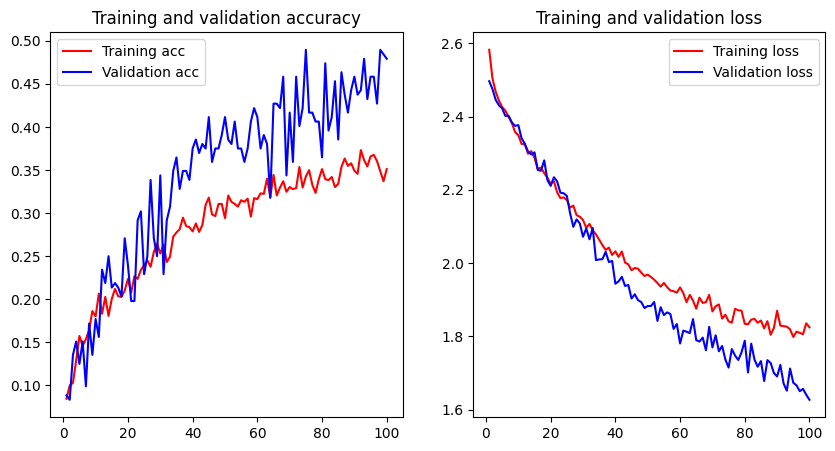

In [10]:
acc = history_res.history['accuracy']
val_acc = history_res.history['val_accuracy']
loss = history_res.history['loss']
val_loss = history_res.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig(os.path.join(model_dir,"{}_acc.png".format(MODEL_NAME)))
plt.subplot(122)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig(os.path.join(model_dir,"{}_acc_loss.png".format(MODEL_NAME)))
plt.show()

        
        


    


As we can see from the resulting curves from the model ResNET, using a transfer learning approach in this case do not provide a better performance than the previous trained models.



# Evaluate models using test_split

In [23]:
MODEL_NAME = ["SimpleCNN","MobileNetV2","ResNetV2"]

model_dir = "../models"
for name in MODEL_NAME:
    model_filepath=os.path.join(model_dir, "bck_{}.h5".format(name))
    print("loading: {}\n".format(name))
    model = tf.keras.models.load_model(model_filepath)

    score = model.evaluate(testing_generator)
    print("Test Loss", score[0])
    print("Test Accuracy", score[1])


loading: SimpleCNN

413/413 [==============================] - 7s 17ms/step - loss: 1.1267 - accuracy: 0.6830
Test Loss 1.1266911029815674
Test Accuracy 0.6829897165298462
loading: MobileNetV2

413/413 [==============================] - 13s 30ms/step - loss: 0.1625 - accuracy: 0.9677
Test Loss 0.16248397529125214
Test Accuracy 0.9677076935768127
loading: ResNetV2

413/413 [==============================] - 32s 75ms/step - loss: 1.7431 - accuracy: 0.3628
Test Loss 1.7431249618530273
Test Accuracy 0.3627956211566925


In [17]:
acc = scoreSeg.history['accuracy']
val_acc = scoreSeg.history['val_accuracy']
loss = scoreSeg.history['loss']
val_loss = scoreSeg.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig(os.path.join(model_dir,"{}_acc.png".format(MODEL_NAME)))
plt.subplot(122)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
#plt.savefig(os.path.join(model_dir,"{}_acc_loss.png".format(MODEL_NAME)))
plt.show()


AttributeError: 'list' object has no attribute 'history'